# Model : LTSM

In [44]:
import pandas as pd
import numpy as np
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

pd.options.mode.chained_assignment = None 

In [176]:
# Load data
df = pd.read_csv("./ohlcv_m6.csv")
print(df)

              Date Symbol       Open       High        Low      Close  \
0       2013-01-02   ABBV  23.848844  24.176665  23.288819  23.985435   
1       2013-01-03   ABBV  23.903484  23.903484  23.329800  23.787382   
2       2013-01-04   ABBV  23.643949  23.828348  23.391256  23.486870   
3       2013-01-07   ABBV  23.322972  24.210815  23.322972  23.534687   
4       2013-01-08   ABBV  23.418585  23.657618  22.783435  23.022469   
...            ...    ...        ...        ...        ...        ...   
542265  2022-02-11    VXX  20.469999  23.870001  20.295000  23.240000   
542266  2022-02-14    VXX  23.309999  24.799999  23.010000  23.309999   
542267  2022-02-15    VXX  21.680000  22.219999  21.330000  21.389999   
542268  2022-02-16    VXX  21.700001  22.139999  20.459999  20.530001   
542269  2022-02-17    VXX  21.709999  23.090000  21.620001  22.959999   

           Volume  
0        13767900  
1        16739300  
2        21372100  
3        17897100  
4        17863300  
...

In [181]:
def make_predictions(df):
    # PARAMETERS
    split_percent = 0.99 # Split ratio for the train/test split
    look_back = 20 # Look back for the LTSM
    num_epochs = 150 # Number of epochs for the LTSM
    num_prediction = 30 # Make forecast for the next month
    
    # Forecast dates
    last_date = df['Date'].values[-1]
    forecast_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    
    # This dataframe stores the forecasts of the next month for every symbols
    res = pd.DataFrame()
    res["Date"] = forecast_dates
    
    # Get list of symbols
    symbols = pd.unique(df["Symbol"].values.ravel())

    for symbol in symbols:
        tf.keras.backend.clear_session()
        print(symbol)
        
        # Get data. Keep only Close values
        dataframe = df[df["Symbol"]==symbol]
        #print("##############",len(dataframe))
        dataframe['Date'] = pd.to_datetime(dataframe['Date'], format="%Y-%m-%d")
        dataframe.set_axis(dataframe['Date'], inplace=True)
        dataframe.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
        close_data = dataframe["Close"].values.reshape(-1,1)
        
        #print("##############",len(close_data))
        
        # Split
        split = int(split_percent*len(close_data))
        close_train = close_data[:split]
        close_test = close_data[split:]
        date_train = dataframe['Date'][:split]
        date_test = dataframe['Date'][split:]
        
        train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
        test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

        # Create the model (LTSM)
        model = Sequential()
        model.add(
            LSTM(10,
                activation='relu',
                input_shape=(look_back,1))
        )
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        dot_img_file = symbol+"_model.png"
        tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

        
        # Fit the model
        model.fit(train_generator, epochs=num_epochs, verbose=2)
        
        # Predictions
        prediction = model.predict(test_generator)

        close_train = close_train.reshape((-1))
        close_test = close_test.reshape((-1))
        prediction = prediction.reshape((-1))
                
        # Make prediction for the next month
        close_data = close_data.reshape((-1))

       
        prediction_list = close_data[-look_back:]

        for _ in range(num_prediction):
            x = prediction_list[-look_back:]
            x = x.reshape((1, look_back, 1))
            out = model.predict(x)[0][0]
            prediction_list = np.append(prediction_list, out)
        forecast = prediction_list[look_back-1:]

        
        # Transform results as dataframes
        df_train = pd.DataFrame({"Date":date_train,"Train" : close_train})
        df_test = pd.DataFrame({"Date":date_test,"Test" : close_test})
        df_prediction = pd.DataFrame({"Date":date_test[look_back:],"Prediction" : prediction})
        df_forecast = pd.DataFrame({"Date":forecast_dates,"Forecast" : forecast})
        res[symbol] = forecast
        
    return res#df_train, df_test, df_prediction, df_forecast
        

In [182]:
#df_train, df_test, df_prediction, df_forecast = make_predictions(df)
forecasts = make_predictions(df)

ABBV
Epoch 1/150
113/113 - 1s - loss: 3227.8950
Epoch 2/150
113/113 - 1s - loss: 1843.5948
Epoch 3/150
113/113 - 1s - loss: 125.5548
Epoch 4/150
113/113 - 1s - loss: 103.6469
Epoch 5/150
113/113 - 1s - loss: 86.3526
Epoch 6/150
113/113 - 1s - loss: 69.9404
Epoch 7/150
113/113 - 1s - loss: 52.8784
Epoch 8/150
113/113 - 1s - loss: 41.3320
Epoch 9/150
113/113 - 1s - loss: 31.5690
Epoch 10/150
113/113 - 1s - loss: 30.1212
Epoch 11/150
113/113 - 1s - loss: 22.6824
Epoch 12/150
113/113 - 1s - loss: 16.6105
Epoch 13/150
113/113 - 1s - loss: 14.2485
Epoch 14/150
113/113 - 1s - loss: 12.0882
Epoch 15/150
113/113 - 1s - loss: 10.7041
Epoch 16/150
113/113 - 1s - loss: 13.0479
Epoch 17/150
113/113 - 1s - loss: 10.7950
Epoch 18/150
113/113 - 1s - loss: 6.9381
Epoch 19/150
113/113 - 1s - loss: 8.5942
Epoch 20/150
113/113 - 1s - loss: 6.4837
Epoch 21/150
113/113 - 1s - loss: 5.1728
Epoch 22/150
113/113 - 1s - loss: 5.5727
Epoch 23/150
113/113 - 1s - loss: 4.3218
Epoch 24/150
113/113 - 1s - loss: 3.89

Epoch 46/150
256/256 - 1s - loss: 231.0955
Epoch 47/150
256/256 - 1s - loss: 251.4357
Epoch 48/150
256/256 - 1s - loss: 247.0452
Epoch 49/150
256/256 - 1s - loss: 266.2596
Epoch 50/150
256/256 - 1s - loss: 252.6256
Epoch 51/150
256/256 - 1s - loss: 229.1425
Epoch 52/150
256/256 - 1s - loss: 246.9360
Epoch 53/150
256/256 - 1s - loss: 256.9616
Epoch 54/150
256/256 - 1s - loss: 285.2557
Epoch 55/150
256/256 - 1s - loss: 291.9703
Epoch 56/150
256/256 - 1s - loss: 336.3496
Epoch 57/150
256/256 - 1s - loss: 317.1784
Epoch 58/150
256/256 - 1s - loss: 444.8642
Epoch 59/150
256/256 - 1s - loss: 957.9200
Epoch 60/150
256/256 - 1s - loss: 847.8087
Epoch 61/150
256/256 - 1s - loss: 1830.5417
Epoch 62/150
256/256 - 1s - loss: 1896.7908
Epoch 63/150
256/256 - 1s - loss: 1515.8579
Epoch 64/150
256/256 - 1s - loss: 1276.7646
Epoch 65/150
256/256 - 1s - loss: 1143.9615
Epoch 66/150
256/256 - 1s - loss: 1062.7885
Epoch 67/150
256/256 - 1s - loss: 1045.8188
Epoch 68/150
256/256 - 1s - loss: 1078.2346
Epo

525/525 - 2s - loss: 0.2442
Epoch 91/150
525/525 - 2s - loss: 0.2513
Epoch 92/150
525/525 - 2s - loss: 0.3131
Epoch 93/150
525/525 - 2s - loss: 0.2145
Epoch 94/150
525/525 - 2s - loss: 0.2295
Epoch 95/150
525/525 - 2s - loss: 0.2349
Epoch 96/150
525/525 - 2s - loss: 0.2517
Epoch 97/150
525/525 - 3s - loss: 0.2545
Epoch 98/150
525/525 - 2s - loss: 0.2549
Epoch 99/150
525/525 - 2s - loss: 0.2502
Epoch 100/150
525/525 - 2s - loss: 0.2300
Epoch 101/150
525/525 - 2s - loss: 0.3293
Epoch 102/150
525/525 - 2s - loss: 0.2572
Epoch 103/150
525/525 - 2s - loss: 0.2683
Epoch 104/150
525/525 - 2s - loss: 0.2317
Epoch 105/150
525/525 - 2s - loss: 0.2676
Epoch 106/150
525/525 - 2s - loss: 0.2135
Epoch 107/150
525/525 - 2s - loss: 0.2560
Epoch 108/150
525/525 - 2s - loss: 0.2058
Epoch 109/150
525/525 - 2s - loss: 1.5667
Epoch 110/150
525/525 - 2s - loss: 0.2645
Epoch 111/150
525/525 - 2s - loss: 0.2185
Epoch 112/150
525/525 - 2s - loss: 0.2146
Epoch 113/150
525/525 - 2s - loss: 0.2148
Epoch 114/150
5

2022-02-20 23:14:51.965197: W tensorflow/core/framework/op_kernel.cc:1751] Invalid argument: ValueError: callback pyfunc_290 is not found
Traceback (most recent call last):

  File "/home/kf/.local/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_290 is not found


2022-02-20 23:14:51.965293: W tensorflow/core/kernels/data/generator_dataset_op.cc:107] Error occurred when finalizing GeneratorDataset iterator: Invalid argument: ValueError: callback pyfunc_290 is not found
Traceback (most recent call last):

  File "/home/kf/.local/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 238, in __call__
    raise ValueError("callback %s is not found" % token)

ValueError: callback pyfunc_290 is not found


	 [[{{node PyFunc}}]]
2022-02-20 23:14:52.206316: W tensorflow/core/framework/op_kernel.cc:1751] Invalid argument: ValueError: callback pyfunc_341 

224/224 - 3s - loss: 3471.0291
Epoch 2/150
224/224 - 1s - loss: 42.3264
Epoch 3/150
224/224 - 1s - loss: 108.1192
Epoch 4/150
224/224 - 1s - loss: 22.8180
Epoch 5/150
224/224 - 1s - loss: 21.4969
Epoch 6/150
224/224 - 1s - loss: 20.1027
Epoch 7/150
224/224 - 1s - loss: 19.6360
Epoch 8/150
224/224 - 1s - loss: 19.6880
Epoch 9/150
224/224 - 1s - loss: 21.6597
Epoch 10/150
224/224 - 1s - loss: 19.8971
Epoch 11/150
224/224 - 1s - loss: 19.8301
Epoch 12/150
224/224 - 1s - loss: 19.0252
Epoch 13/150
224/224 - 1s - loss: 22.6973
Epoch 14/150
224/224 - 1s - loss: 32.3868
Epoch 15/150
224/224 - 1s - loss: 23.7790
Epoch 16/150
224/224 - 1s - loss: 23.3037
Epoch 17/150
224/224 - 1s - loss: 19.4210
Epoch 18/150
224/224 - 1s - loss: 24.4873
Epoch 19/150
224/224 - 1s - loss: 10.4640
Epoch 20/150
224/224 - 1s - loss: 8.7084
Epoch 21/150
224/224 - 1s - loss: 3.9170
Epoch 22/150
224/224 - 1s - loss: 3.1799
Epoch 23/150
224/224 - 1s - loss: 3.0097
Epoch 24/150
224/224 - 1s - loss: 5.3285
Epoch 25/150
22

Epoch 49/150
102/102 - 0s - loss: 2.4992
Epoch 50/150
102/102 - 0s - loss: 2.9248
Epoch 51/150
102/102 - 0s - loss: 3.1234
Epoch 52/150
102/102 - 0s - loss: 2.7627
Epoch 53/150
102/102 - 0s - loss: 2.8916
Epoch 54/150
102/102 - 0s - loss: 3.2665
Epoch 55/150
102/102 - 0s - loss: 3.6982
Epoch 56/150
102/102 - 1s - loss: 2.6791
Epoch 57/150
102/102 - 0s - loss: 2.9038
Epoch 58/150
102/102 - 1s - loss: 2.7451
Epoch 59/150
102/102 - 1s - loss: 2.8846
Epoch 60/150
102/102 - 0s - loss: 2.7368
Epoch 61/150
102/102 - 0s - loss: 2.8636
Epoch 62/150
102/102 - 0s - loss: 2.6268
Epoch 63/150
102/102 - 0s - loss: 2.7715
Epoch 64/150
102/102 - 1s - loss: 3.0292
Epoch 65/150
102/102 - 0s - loss: 3.0399
Epoch 66/150
102/102 - 1s - loss: 2.7245
Epoch 67/150
102/102 - 1s - loss: 2.8644
Epoch 68/150
102/102 - 0s - loss: 2.8056
Epoch 69/150
102/102 - 0s - loss: 3.1503
Epoch 70/150
102/102 - 0s - loss: 2.9004
Epoch 71/150
102/102 - 0s - loss: 2.7486
Epoch 72/150
102/102 - 1s - loss: 3.0870
Epoch 73/150
102

Epoch 98/150
523/523 - 2s - loss: 0.9027
Epoch 99/150
523/523 - 2s - loss: 0.7023
Epoch 100/150
523/523 - 2s - loss: 0.9356
Epoch 101/150
523/523 - 2s - loss: 0.7688
Epoch 102/150
523/523 - 2s - loss: 1.0252
Epoch 103/150
523/523 - 2s - loss: 1.5338
Epoch 104/150
523/523 - 3s - loss: 0.7308
Epoch 105/150
523/523 - 2s - loss: 1.0141
Epoch 106/150
523/523 - 3s - loss: 18.4550
Epoch 107/150
523/523 - 2s - loss: 1.3810
Epoch 108/150
523/523 - 2s - loss: 0.6974
Epoch 109/150
523/523 - 2s - loss: 0.6099
Epoch 110/150
523/523 - 2s - loss: 0.5770
Epoch 111/150
523/523 - 2s - loss: 0.5893
Epoch 112/150
523/523 - 3s - loss: 0.5637
Epoch 113/150
523/523 - 2s - loss: 0.5449
Epoch 114/150
523/523 - 3s - loss: 33.0051
Epoch 115/150
523/523 - 2s - loss: 1.7875
Epoch 116/150
523/523 - 2s - loss: 2.1836
Epoch 117/150
523/523 - 2s - loss: 0.8614
Epoch 118/150
523/523 - 2s - loss: 10.5837
Epoch 119/150
523/523 - 2s - loss: 7.6074
Epoch 120/150
523/523 - 2s - loss: 3.5155
Epoch 121/150
523/523 - 3s - loss

204/204 - 1s - loss: 4.2115
Epoch 145/150
204/204 - 1s - loss: 4.4057
Epoch 146/150
204/204 - 1s - loss: 4.3111
Epoch 147/150
204/204 - 1s - loss: 4.3077
Epoch 148/150
204/204 - 1s - loss: 4.3390
Epoch 149/150
204/204 - 1s - loss: 4.2782
Epoch 150/150
204/204 - 1s - loss: 5.0107
AMZN
Epoch 1/150
308/308 - 2s - loss: 1028143.1250
Epoch 2/150
308/308 - 1s - loss: 820246.7500
Epoch 3/150
308/308 - 1s - loss: 128103.4531
Epoch 4/150
308/308 - 1s - loss: 45648.9688
Epoch 5/150
308/308 - 1s - loss: 17460.2852
Epoch 6/150
308/308 - 1s - loss: 7787.5747
Epoch 7/150
308/308 - 1s - loss: 5134.7310
Epoch 8/150
308/308 - 2s - loss: 4845.1768
Epoch 9/150
308/308 - 1s - loss: 4786.6616
Epoch 10/150
308/308 - 1s - loss: 4765.2031
Epoch 11/150
308/308 - 1s - loss: 4688.9341
Epoch 12/150
308/308 - 2s - loss: 4566.2349
Epoch 13/150
308/308 - 1s - loss: 3770.7881
Epoch 14/150
308/308 - 1s - loss: 4375.4570
Epoch 15/150
308/308 - 2s - loss: 3531.8022
Epoch 16/150
308/308 - 1s - loss: 3560.4084
Epoch 17/15

Epoch 30/150
348/348 - 2s - loss: 30.0912
Epoch 31/150
348/348 - 2s - loss: 29.3816
Epoch 32/150
348/348 - 2s - loss: 59.1737
Epoch 33/150
348/348 - 2s - loss: 33.9401
Epoch 34/150
348/348 - 2s - loss: 24.7571
Epoch 35/150
348/348 - 2s - loss: 34.0472
Epoch 36/150
348/348 - 2s - loss: 28.1128
Epoch 37/150
348/348 - 2s - loss: 50.4506
Epoch 38/150
348/348 - 2s - loss: 29.8549
Epoch 39/150
348/348 - 2s - loss: 25.1180
Epoch 40/150
348/348 - 2s - loss: 34.2112
Epoch 41/150
348/348 - 2s - loss: 31.8593
Epoch 42/150
348/348 - 2s - loss: 44.4848
Epoch 43/150
348/348 - 2s - loss: 51.5020
Epoch 44/150
348/348 - 2s - loss: 28.9395
Epoch 45/150
348/348 - 2s - loss: 44.3780
Epoch 46/150
348/348 - 2s - loss: 30.2072
Epoch 47/150
348/348 - 2s - loss: 55.7318
Epoch 48/150
348/348 - 2s - loss: 40.6476
Epoch 49/150
348/348 - 2s - loss: 33.7414
Epoch 50/150
348/348 - 2s - loss: 36.0277
Epoch 51/150
348/348 - 2s - loss: 64.8768
Epoch 52/150
348/348 - 2s - loss: 37.8498
Epoch 53/150
348/348 - 2s - loss: 

Epoch 77/150
525/525 - 2s - loss: 1.3062
Epoch 78/150
525/525 - 2s - loss: 4.9723
Epoch 79/150
525/525 - 2s - loss: 6.9176
Epoch 80/150
525/525 - 3s - loss: 24.2520
Epoch 81/150
525/525 - 2s - loss: 9.9116
Epoch 82/150
525/525 - 2s - loss: 6.3715
Epoch 83/150
525/525 - 3s - loss: 6.4573
Epoch 84/150
525/525 - 2s - loss: 5.8798
Epoch 85/150
525/525 - 2s - loss: 4.4707
Epoch 86/150
525/525 - 2s - loss: 3.7995
Epoch 87/150
525/525 - 2s - loss: 4.3413
Epoch 88/150
525/525 - 2s - loss: 3.5645
Epoch 89/150
525/525 - 2s - loss: 3.0269
Epoch 90/150
525/525 - 2s - loss: 1.3718
Epoch 91/150
525/525 - 2s - loss: 1.3411
Epoch 92/150
525/525 - 2s - loss: 2.0049
Epoch 93/150
525/525 - 2s - loss: 1.5584
Epoch 94/150
525/525 - 2s - loss: 1.9578
Epoch 95/150
525/525 - 2s - loss: 1.2752
Epoch 96/150
525/525 - 2s - loss: 8.1469
Epoch 97/150
525/525 - 2s - loss: 6.5538
Epoch 98/150
525/525 - 2s - loss: 4.9310
Epoch 99/150
525/525 - 3s - loss: 6.9458
Epoch 100/150
525/525 - 2s - loss: 4.4694
Epoch 101/150


Epoch 125/150
525/525 - 2s - loss: 2.9637
Epoch 126/150
525/525 - 2s - loss: 1.0134
Epoch 127/150
525/525 - 3s - loss: 0.8898
Epoch 128/150
525/525 - 3s - loss: 0.9261
Epoch 129/150
525/525 - 2s - loss: 1.0408
Epoch 130/150
525/525 - 3s - loss: 0.8318
Epoch 131/150
525/525 - 2s - loss: 0.9033
Epoch 132/150
525/525 - 3s - loss: 0.8646
Epoch 133/150
525/525 - 2s - loss: 0.9152
Epoch 134/150
525/525 - 2s - loss: 1.1107
Epoch 135/150
525/525 - 3s - loss: 0.9966
Epoch 136/150
525/525 - 3s - loss: 0.9733
Epoch 137/150
525/525 - 2s - loss: 0.8380
Epoch 138/150
525/525 - 3s - loss: 0.9252
Epoch 139/150
525/525 - 2s - loss: 0.9715
Epoch 140/150
525/525 - 2s - loss: 1.6747
Epoch 141/150
525/525 - 2s - loss: 0.8761
Epoch 142/150
525/525 - 2s - loss: 0.9672
Epoch 143/150
525/525 - 3s - loss: 0.8273
Epoch 144/150
525/525 - 2s - loss: 0.8868
Epoch 145/150
525/525 - 3s - loss: 0.8388
Epoch 146/150
525/525 - 2s - loss: 0.9119
Epoch 147/150
525/525 - 3s - loss: 0.9596
Epoch 148/150
525/525 - 3s - loss:

523/523 - 2s - loss: 0.1585
Epoch 23/150
523/523 - 2s - loss: 0.1605
Epoch 24/150
523/523 - 2s - loss: 0.6652
Epoch 25/150
523/523 - 2s - loss: 0.2869
Epoch 26/150
523/523 - 2s - loss: 0.2972
Epoch 27/150
523/523 - 2s - loss: 0.2685
Epoch 28/150
523/523 - 2s - loss: 0.5913
Epoch 29/150
523/523 - 2s - loss: 0.1716
Epoch 30/150
523/523 - 2s - loss: 0.3467
Epoch 31/150
523/523 - 2s - loss: 0.9263
Epoch 32/150
523/523 - 2s - loss: 0.6843
Epoch 33/150
523/523 - 2s - loss: 0.2099
Epoch 34/150
523/523 - 2s - loss: 0.5276
Epoch 35/150
523/523 - 2s - loss: 0.1921
Epoch 36/150
523/523 - 2s - loss: 0.6804
Epoch 37/150
523/523 - 2s - loss: 0.1730
Epoch 38/150
523/523 - 2s - loss: 0.1537
Epoch 39/150
523/523 - 2s - loss: 0.3873
Epoch 40/150
523/523 - 2s - loss: 0.2408
Epoch 41/150
523/523 - 2s - loss: 0.2126
Epoch 42/150
523/523 - 2s - loss: 0.2219
Epoch 43/150
523/523 - 2s - loss: 2.4926
Epoch 44/150
523/523 - 2s - loss: 0.1909
Epoch 45/150
523/523 - 2s - loss: 0.1658
Epoch 46/150
523/523 - 2s - l

Epoch 71/150
525/525 - 3s - loss: 0.2177
Epoch 72/150
525/525 - 2s - loss: 0.2255
Epoch 73/150
525/525 - 3s - loss: 0.2189
Epoch 74/150
525/525 - 3s - loss: 0.2596
Epoch 75/150
525/525 - 3s - loss: 0.2350
Epoch 76/150
525/525 - 3s - loss: 0.2138
Epoch 77/150
525/525 - 3s - loss: 0.2103
Epoch 78/150
525/525 - 3s - loss: 0.3122
Epoch 79/150
525/525 - 3s - loss: 0.2056
Epoch 80/150
525/525 - 3s - loss: 0.2099
Epoch 81/150
525/525 - 3s - loss: 0.2092
Epoch 82/150
525/525 - 3s - loss: 0.2092
Epoch 83/150
525/525 - 3s - loss: 0.2243
Epoch 84/150
525/525 - 2s - loss: 0.2744
Epoch 85/150
525/525 - 2s - loss: 0.2136
Epoch 86/150
525/525 - 2s - loss: 0.2101
Epoch 87/150
525/525 - 2s - loss: 0.2080
Epoch 88/150
525/525 - 2s - loss: 0.2158
Epoch 89/150
525/525 - 3s - loss: 0.2540
Epoch 90/150
525/525 - 3s - loss: 0.2061
Epoch 91/150
525/525 - 2s - loss: 0.2306
Epoch 92/150
525/525 - 2s - loss: 0.2151
Epoch 93/150
525/525 - 3s - loss: 0.2168
Epoch 94/150
525/525 - 2s - loss: 0.2239
Epoch 95/150
525

185/185 - 1s - loss: 1.7628
Epoch 118/150
185/185 - 1s - loss: 1.7196
Epoch 119/150
185/185 - 1s - loss: 1.7402
Epoch 120/150
185/185 - 1s - loss: 1.7691
Epoch 121/150
185/185 - 1s - loss: 1.6343
Epoch 122/150
185/185 - 1s - loss: 1.6534
Epoch 123/150
185/185 - 1s - loss: 1.7922
Epoch 124/150
185/185 - 1s - loss: 1.6995
Epoch 125/150
185/185 - 1s - loss: 1.7610
Epoch 126/150
185/185 - 1s - loss: 2.7032
Epoch 127/150
185/185 - 1s - loss: 1.8093
Epoch 128/150
185/185 - 1s - loss: 1.6991
Epoch 129/150
185/185 - 1s - loss: 1.7354
Epoch 130/150
185/185 - 1s - loss: 1.7357
Epoch 131/150
185/185 - 1s - loss: 1.6720
Epoch 132/150
185/185 - 1s - loss: 1.8028
Epoch 133/150
185/185 - 1s - loss: 1.7224
Epoch 134/150
185/185 - 1s - loss: 1.6642
Epoch 135/150
185/185 - 1s - loss: 1.6123
Epoch 136/150
185/185 - 1s - loss: 4.9373
Epoch 137/150
185/185 - 1s - loss: 1.7046
Epoch 138/150
185/185 - 1s - loss: 1.6756
Epoch 139/150
185/185 - 1s - loss: 46.6723
Epoch 140/150
185/185 - 1s - loss: 8.1469
Epoch

ValueError: `start_index+length=20 > end_index=4` is disallowed, as no part of the sequence would be left to be used as current step.

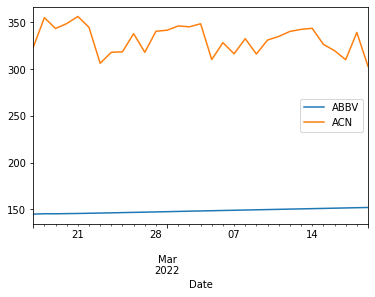

In [175]:
forecasts.plot(x="Date", y=list(forecasts.columns[1:]), label=list(forecasts.columns[1:]))
plt.show()